In [15]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357287 sha256=d28fe195b0e4f56752e04fef753f2dd363876dd8499f54d9a47ab5c27ac4d1d0
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [1]:
import numpy as np
import pandas as pd

In [2]:
data=pd.read_csv('/content/drive/MyDrive/faker_data.csv')

In [3]:
data.head()

,customer_id,product_name,product_id,interaction_type,interaction_date
0,93363fcf-9748-4dad-a018-ccb23585f914,Savings accounts,2,purchased,2024-07-11
1,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,purchased,2024-06-12
2,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,clicked,2024-11-13
3,93363fcf-9748-4dad-a018-ccb23585f914,Insurance,8,viewed,2024-08-21
4,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,clicked,2024-09-25


In [4]:
data.describe()

,product_id
count,1500.000000
mean,4.436667
std,2.293795
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,8.000000


In [5]:
data.nunique()

,0
customer_id,100
product_name,8
product_id,8
interaction_type,3
interaction_date,340


In [7]:
data.shape

(1500, 5)

In [9]:
data.isnull().sum()

,0
customer_id,0
product_name,0
product_id,0
interaction_type,0
interaction_date,0


In [10]:
from sklearn.preprocessing import LabelEncoder

# Define columns that need label encoding (here it's just 'interaction_type')
label_encodable = ['interaction_type']

# Create a LabelEncoder instance for each column
label_encoders = {col: LabelEncoder() for col in label_encodable}

# Apply label encoding to the specified columns
for col in label_encodable:
    data[col] = label_encoders[col].fit_transform(data[col])

data.head(10)


,customer_id,product_name,product_id,interaction_type,interaction_date
0,93363fcf-9748-4dad-a018-ccb23585f914,Savings accounts,2,1,2024-07-11
1,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,1,2024-06-12
2,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,0,2024-11-13
3,93363fcf-9748-4dad-a018-ccb23585f914,Insurance,8,2,2024-08-21
4,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,0,2024-09-25
5,93363fcf-9748-4dad-a018-ccb23585f914,Credit cards,6,2,2024-02-21
6,93363fcf-9748-4dad-a018-ccb23585f914,Mobile banking,4,2,2024-09-30
7,93363fcf-9748-4dad-a018-ccb23585f914,Loans,1,1,2024-10-29
8,93363fcf-9748-4dad-a018-ccb23585f914,Financial education,5,2,2024-07-15
9,93363fcf-9748-4dad-a018-ccb23585f914,Mobile banking,4,2,2024-05-11


In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Step 1: Create an interaction matrix
data_pivot = data.pivot_table(index='customer_id', columns='product_id', values='interaction_type', aggfunc='max').fillna(0)

# Step 2: Apply Matrix Factorization using SVD
svd = TruncatedSVD(n_components=8)  # You can adjust the number of latent factors
matrix_factorization = svd.fit_transform(data_pivot)

# Step 3: Reconstruct the matrix and predict missing interactions
predicted_matrix = np.dot(matrix_factorization, svd.components_)

# Step 4: Generate product recommendations
def get_top_n_recommendations(customer_id, top_n=5):
    customer_index = data_pivot.index.get_loc(customer_id)
    customer_predictions = predicted_matrix[customer_index]

    # Get the indices of the top_n recommendations
    recommended_indices = customer_predictions.argsort()[-top_n:][::-1]

    # Get the corresponding product ids
    recommended_products = data_pivot.columns[recommended_indices]
    return recommended_products

# Example: Get top 5 product recommendations for a specific customer
customer_id = '93363fcf-9748-4dad-a018-ccb23585f914'
top_recommendations = get_top_n_recommendations(customer_id, top_n=5)
print(f"Top 5 recommended products for customer {customer_id}: {top_recommendations}")


Top 5 recommended products for customer 93363fcf-9748-4dad-a018-ccb23585f914: Index([6, 4, 5, 8, 1], dtype='int64', name='product_id')


In [24]:
from sklearn.metrics import precision_score, recall_score

def calculate_precision_recall(actual, recommended, top_n=5):
    # Binary arrays for actual vs recommended (1 if the product was interacted with, 0 otherwise)
    # Create y_true with the size of all possible products
    y_true = np.zeros(len(data['product_id'].unique()))
    y_pred = np.zeros(len(data['product_id'].unique()))

    # The indices of actual products in the entire product space
    actual_indices = np.where(np.isin(data['product_id'].unique(), actual))[0]

    # Mark actual interactions
    y_true[actual_indices] = 1

    # The indices of recommended products in the entire product space
    recommended_indices = np.where(np.isin(data['product_id'].unique(), recommended[:top_n]))[0]

    # Mark recommended interactions
    y_pred[recommended_indices] = 1

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return precision, recall

# Calculate precision and recall for a customer
actual_interactions = data[data['customer_id'] == customer_id]['product_id'].values
recommended_products = get_top_n_recommendations(customer_id, top_n=5)

precision, recall = calculate_precision_recall(actual_interactions, recommended_products)
print(f"Precision: {precision}, Recall: {recall}")


Precision: 1.0, Recall: 0.7142857142857143


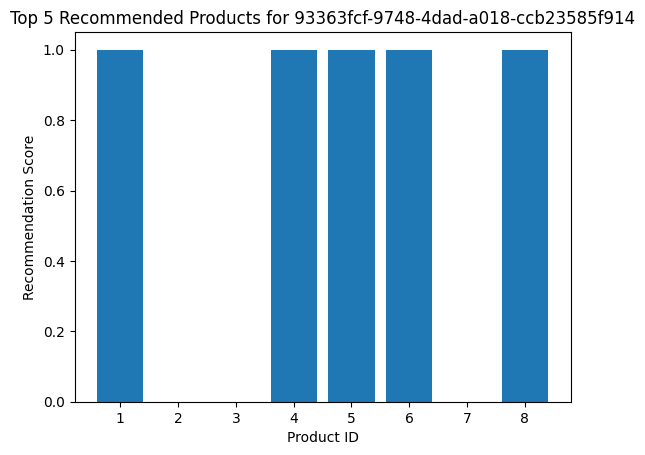

In [26]:
import matplotlib.pyplot as plt

# Example function to plot top N recommended products
def plot_recommended_products(customer_id, top_n=5):
    recommended_products = get_top_n_recommendations(customer_id, top_n)

    # Plotting the recommended products
    plt.bar(recommended_products, height=np.ones_like(recommended_products))
    plt.xlabel('Product ID')
    plt.ylabel('Recommendation Score')
    plt.title(f'Top {top_n} Recommended Products for {customer_id}')
    plt.show()

plot_recommended_products(customer_id)


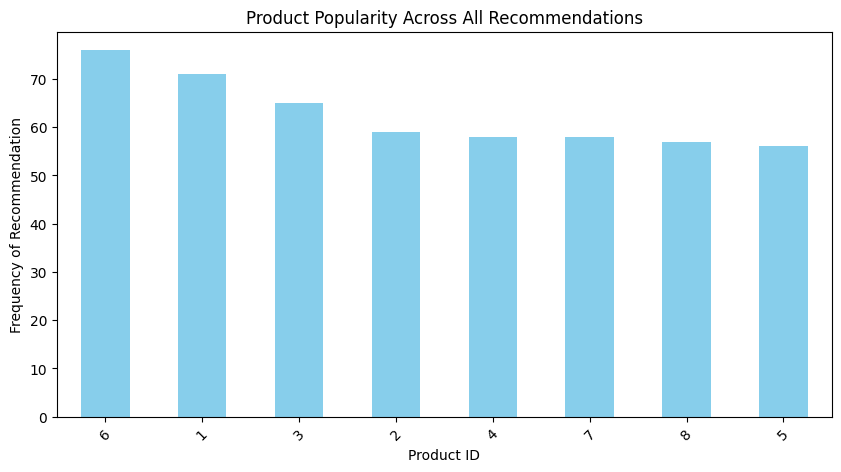

In [30]:
product_counts = []

# Count how many times each product is recommended
for customer_id in data['customer_id'].unique():
    recommended_products = get_top_n_recommendations(customer_id, top_n=5)
    product_counts.extend(recommended_products)

# Plot product popularity
product_popularity = pd.Series(product_counts).value_counts()

plt.figure(figsize=(10, 5))
product_popularity.plot(kind='bar', color='skyblue')
plt.title('Product Popularity Across All Recommendations')
plt.xlabel('Product ID')
plt.ylabel('Frequency of Recommendation')
plt.xticks(rotation=45)
plt.show()


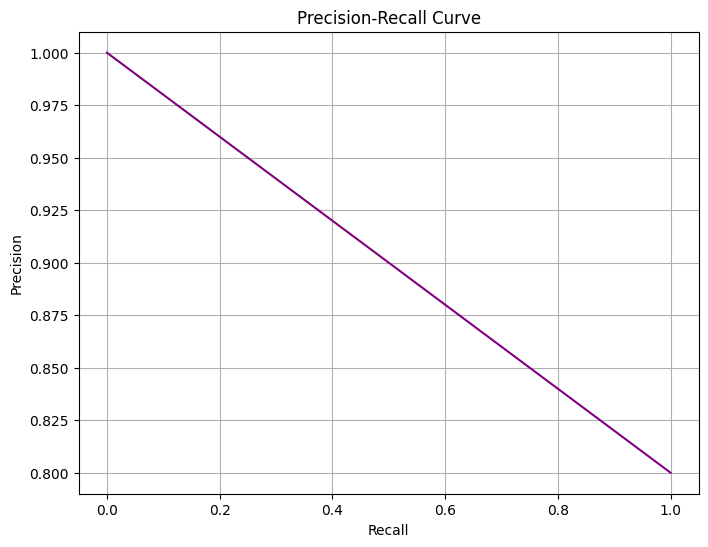

In [31]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for all customers
precisions, recalls, _ = precision_recall_curve(
    np.array([1 if x in actual_interactions else 0 for x in recommended_products]),
    np.array([1 for _ in range(len(recommended_products))])
)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='purple')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
